# Scaling

## MTZ IO

``ess.nmx`` has ``MTZ`` IO helper functions.
They can be used as providers in a workflow of scaling routine.

They are wrapping ``MTZ`` IO functions of ``gemmi``.

In [24]:
%matplotlib inline

In [25]:
import gemmi
from ess.nmx.mtz_io import (
    read_mtz_file,
    mtz_to_pandas,
    MTZFilePath,
    get_unique_space_group,
    MtzDataFrame,
    merge_mtz_dataframes,
)
from ess.nmx.data import get_small_random_mtz_samples


small_mtz_sample = get_small_random_mtz_samples()[0]
mtz = read_mtz_file(MTZFilePath(small_mtz_sample))
df = mtz_to_pandas(mtz)
df.head()

,H,K,L,I,SIGI,LAMBDA
0,77.0,86.0,25.0,128.635559,13.982677,3.199853
1,-94.0,16.0,-97.0,125.032700,18.123026,3.199840
2,66.0,64.0,65.0,124.352806,18.086149,3.199792
3,10.0,24.0,-38.0,119.595375,17.432163,3.199728
4,99.0,24.0,77.0,118.795967,16.080606,3.199711


## Build Pipeline

Scaling routine includes:
- Reducing individual MTZ dataset
- Merging MTZ dataset 
- Reducing merged MTZ dataset

These operations are done on pandas dataframe as recommended in ``gemmi``.
And multiple MTZ files are expected, so we need to use ``sciline.ParamTable``.
<!--TODO: Update it to use cyclebane instead of ParamTable if needed.-->

In [26]:
import pandas as pd
import sciline as sl
import scipp as sc

from ess.nmx.mtz_io import providers as mtz_io_providers, default_parameters as mtz_io_params
from ess.nmx.mtz_io import SpaceGroupDesc
from ess.nmx.scaling import providers as scaling_providers, default_parameters as scaling_params
from ess.nmx.scaling import (
    WavelengthBins,
    FilteredEstimatedScaledIntensities,
    ReferenceWavelength,
    ScaledIntensityLeftTailThreshold,
    ScaledIntensityRightTailThreshold,
)

pl = sl.Pipeline(
    providers=mtz_io_providers + scaling_providers,
    params={
        SpaceGroupDesc: "C 1 2 1",
        ReferenceWavelength: sc.scalar(
            3, unit=sc.units.angstrom
        ),  # Remove it if you want to use the middle of the bin
        ScaledIntensityLeftTailThreshold: sc.scalar(
            0.1,  # Increase it to remove more outliers
        ),
        ScaledIntensityRightTailThreshold: sc.scalar(
            4.0,  # Decrease it to remove more outliers
        ),
        **mtz_io_params,
        **scaling_params,
        WavelengthBins: 250,
    },
)
pl

In [27]:
file_paths = pd.DataFrame({MTZFilePath: get_small_random_mtz_samples()}).rename_axis(
    "mtzfile"
)
mapped = pl.map(file_paths)
pl[gemmi.SpaceGroup] = mapped[gemmi.SpaceGroup | None].reduce(
    index='mtzfile', func=get_unique_space_group
)
pl[MtzDataFrame] = mapped[MtzDataFrame].reduce(
    index='mtzfile', func=merge_mtz_dataframes
)

## Build Workflow

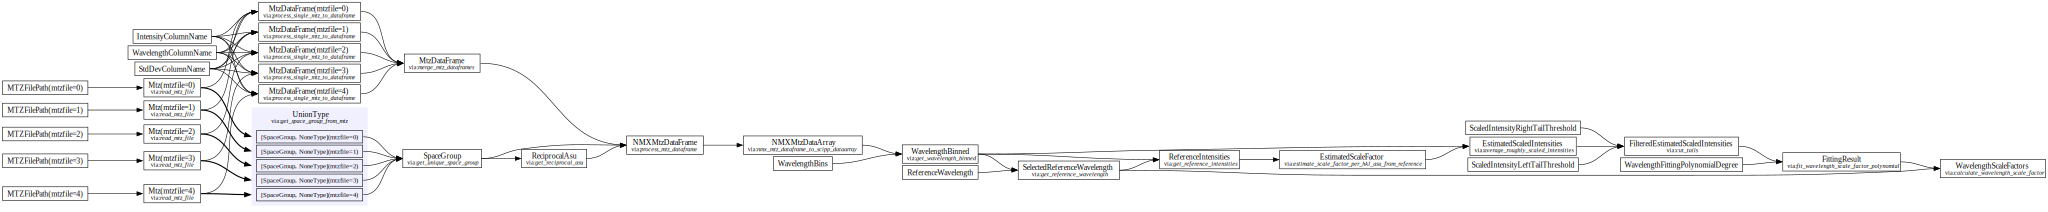

In [28]:
from ess.nmx.scaling import WavelengthScaleFactors

scaling_nmx_workflow = pl.get(WavelengthScaleFactors)
scaling_nmx_workflow.visualize(graph_attr={"rankdir": "LR"})

## Compute Desired Type

In [29]:
from ess.nmx.scaling import (
    SelectedReferenceWavelength,
    FittingResult,
    WavelengthScaleFactors,
)

results = scaling_nmx_workflow.compute(
    (
        FilteredEstimatedScaledIntensities,
        SelectedReferenceWavelength,
        FittingResult,
        WavelengthScaleFactors,
    )
)

results[WavelengthScaleFactors]

<scipp.DataArray>
Dimensions: Sizes[wavelength:247, ]
Coordinates:
* wavelength                float32             [Å]  (wavelength)  [2.80127, 2.80446, ..., 3.19441, 3.196]
Data:
                            float64  [dimensionless]  (wavelength)  [0.1121, 0.15726, ..., 1.84284, 1.86547]

## Plots

Here are plotting examples of the fitting/estimation results.

### Estimated Scaled Intensities.

Text(0.5, 1.0, 'Filtered Estimated Scaled Intensities\nProbability Plot')

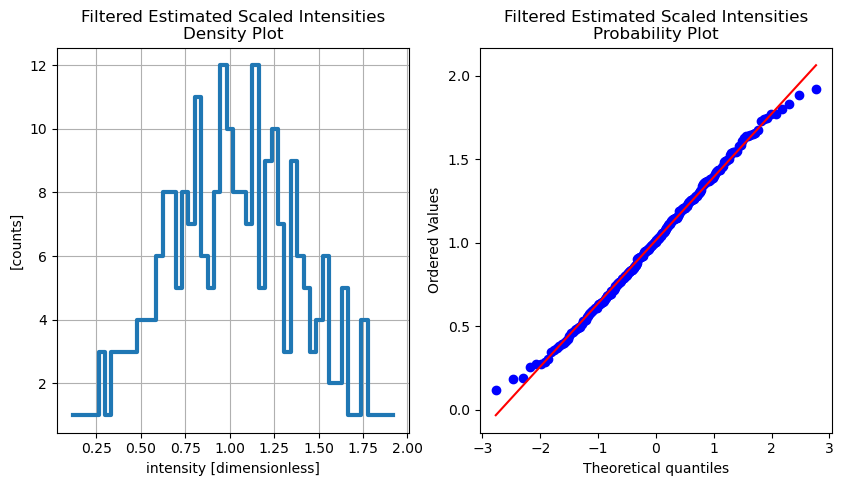

In [30]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, (density_ax, prob_ax) = plt.subplots(1, 2, figsize=(10, 5))

densities = sc.values(results[FilteredEstimatedScaledIntensities].data).values
sc.values(results[FilteredEstimatedScaledIntensities].data).hist(intensity=50).plot(
    title="Filtered Estimated Scaled Intensities\nDensity Plot",
    grid=True,
    linewidth=3,
    ax=density_ax,
)
stats.probplot(densities, dist="norm", plot=prob_ax)
prob_ax.set_title("Filtered Estimated Scaled Intensities\nProbability Plot")

### Curve Fitting

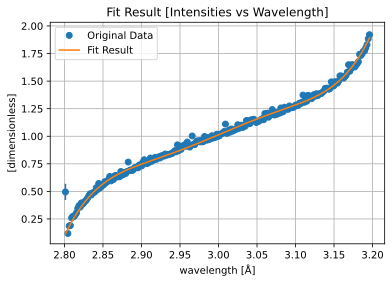

In [31]:
import plopp as pp
import numpy as np
from ess.nmx.scaling import FittingResult

chebyshev_func = np.polynomial.chebyshev.Chebyshev(np.array([1, -1, 1]))
scale_function = np.vectorize(
    chebyshev_func / chebyshev_func(results[SelectedReferenceWavelength].value)
)
pp.plot(
    {
        "Original Data": results[FilteredEstimatedScaledIntensities],
        "Fit Result": results[FittingResult].fit_output,
    },
    grid=True,
    title="Fit Result [Intensities vs Wavelength]",
    marker={"Chebyshev": None, "Fit Result": None},
    linestyle={"Chebyshev": "solid", "Fit Result": "solid"},
)

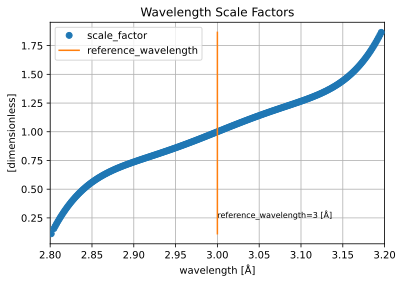

In [32]:
reference_wavelength = sc.DataArray(
    data=sc.concat(
        [
            results[WavelengthScaleFactors].data.min(),
            results[WavelengthScaleFactors].data.max(),
        ],
        "wavelength",
    ),
    coords={
        "wavelength": sc.broadcast(
            results[SelectedReferenceWavelength], dims=["wavelength"], shape=[2]
        )
    },
)
wavelength_scale_factor_plot = pp.plot(
    {
        "scale_factor": results[WavelengthScaleFactors],
        "reference_wavelength": reference_wavelength,
    },
    title="Wavelength Scale Factors",
    grid=True,
    marker={"reference_wavelength": None},
    linestyle={"reference_wavelength": "solid"},
)
wavelength_scale_factor_plot.ax.set_xlim(2.8, 3.2)
reference_wavelength = results[SelectedReferenceWavelength].value
wavelength_scale_factor_plot.ax.text(
    3.0,
    0.25,
    f"{reference_wavelength=:} [{results[SelectedReferenceWavelength].unit}]",
    fontsize=8,
    color="black",
)
wavelength_scale_factor_plot

## Change Provider
Here is an example of how to insert different filter function.

In this example, we will swap a provider that filters ``EstimatedScaledIntensities`` and provide ``FilteredEstimatedScaledIntensities``.

After updating the providers, you can go back to [Compute Desired Type](#Compute-Desired-Type) and start over.

In [33]:
from typing import NewType
import scipp as sc
from ess.nmx.scaling import (
    EstimatedScaledIntensities,
    FilteredEstimatedScaledIntensities,
)

# Define the new types for the filtering function
NRoot = NewType("NRoot", int)
"""The n-th root to be taken for the standard deviation."""
NRootStdDevCut = NewType("NRootStdDevCut", float)
"""The number of standard deviations to be cut from the n-th root data."""


def _calculate_sample_standard_deviation(var: sc.Variable) -> sc.Variable:
    """Calculate the sample variation of the data.

    This helper function is a temporary solution before
    we release new scipp version with the statistics helper.
    """
    import numpy as np

    return sc.scalar(np.nanstd(var.values))


# Define the filtering function with right argument types and return type
def cut_estimated_scaled_intensities_by_n_root_std_dev(
    scaled_intensities: EstimatedScaledIntensities,
    n_root: NRoot,
    n_root_std_dev_cut: NRootStdDevCut,
) -> FilteredEstimatedScaledIntensities:
    """Filter the mtz data array by the quad root of the sample standard deviation.

    Parameters
    ----------
    scaled_intensities:
        The scaled intensities to be filtered.

    n_root:
        The n-th root to be taken for the standard deviation.
        Higher n-th root means cutting is more effective on the right tail.
        More explanation can be found in the notes.

    n_root_std_dev_cut:
        The number of standard deviations to be cut from the n-th root data.

    Returns
    -------
    :
        The filtered scaled intensities.

    """
    # Check the range of the n-th root
    if n_root < 1:
        raise ValueError("The n-th root should be equal to or greater than 1.")

    copied = scaled_intensities.copy(deep=False)
    nth_root = copied.data ** (1 / n_root)
    # Calculate the mean
    nth_root_mean = nth_root.nanmean()
    # Calculate the sample standard deviation
    nth_root_std_dev = _calculate_sample_standard_deviation(nth_root)
    # Calculate the cut value
    half_window = n_root_std_dev_cut * nth_root_std_dev
    keep_range = (nth_root_mean - half_window, nth_root_mean + half_window)

    # Filter the data
    return FilteredEstimatedScaledIntensities(
        copied[(nth_root > keep_range[0]) & (nth_root < keep_range[1])]
    )


pl.insert(cut_estimated_scaled_intensities_by_n_root_std_dev)
pl[NRoot] = 4
pl[NRootStdDevCut] = 1.0

pl.compute(FilteredEstimatedScaledIntensities)

<scipp.DataArray>
Dimensions: Sizes[wavelength:180, ]
Coordinates:
* wavelength                float32             [Å]  (wavelength)  [2.8572, 2.8588, ..., 3.14327, 3.14486]
Data:
                            float32  [dimensionless]  (wavelength)  [0.607011, 0.635432, ..., 1.4263, 1.43293]  [5.74795e-05, 9.93314e-05, ..., 0.000241191, 0.000251346]